In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('th1.csv')

# Hiển thị thông tin chung về DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     365 non-null    object 
 1   1       365 non-null    float64
 2   2       365 non-null    float64
 3   3       365 non-null    float64
 4   4       365 non-null    float64
 5   5       365 non-null    float64
 6   6       365 non-null    float64
 7   7       365 non-null    float64
 8   8       365 non-null    float64
 9   9       365 non-null    float64
 10  10      365 non-null    float64
 11  11      365 non-null    float64
 12  12      365 non-null    float64
 13  13      365 non-null    float64
 14  14      365 non-null    float64
 15  15      365 non-null    float64
 16  16      365 non-null    float64
 17  17      365 non-null    float64
 18  18      365 non-null    float64
 19  19      365 non-null    float64
 20  20      365 non-null    float64
 21  21      365 non-null    float64
 22  22

EDA

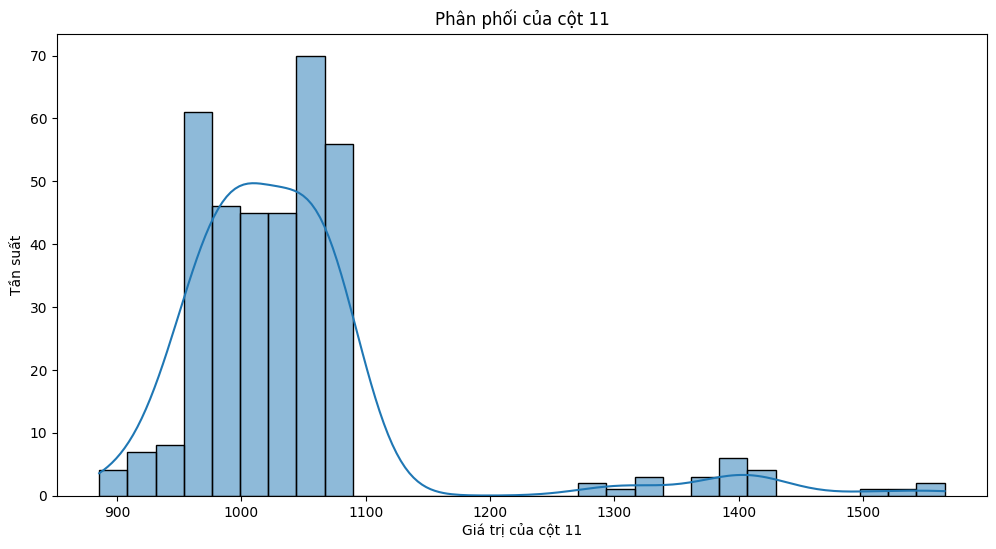

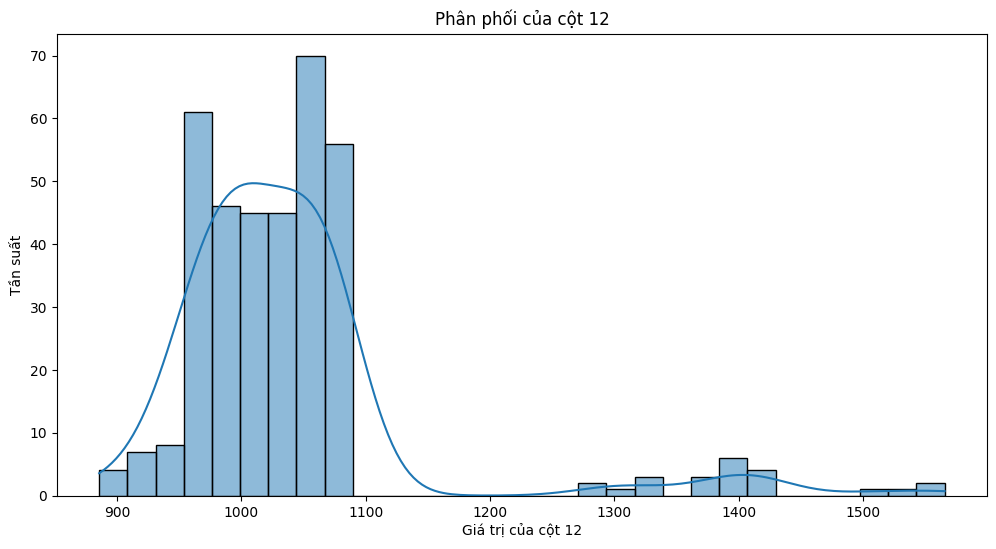

In [3]:
# Biểu đồ phân phối cho cột '11'
plt.figure(figsize=(12, 6))
sns.histplot(df['11'], bins=30, kde=True)
plt.title('Phân phối của cột 11')
plt.xlabel('Giá trị của cột 11')
plt.ylabel('Tần suất')
plt.show()

# Biểu đồ phân phối cho cột '12'
plt.figure(figsize=(12, 6))
sns.histplot(df['12'], bins=30, kde=True)
plt.title('Phân phối của cột 12')
plt.xlabel('Giá trị của cột 12')
plt.ylabel('Tần suất')
plt.show()


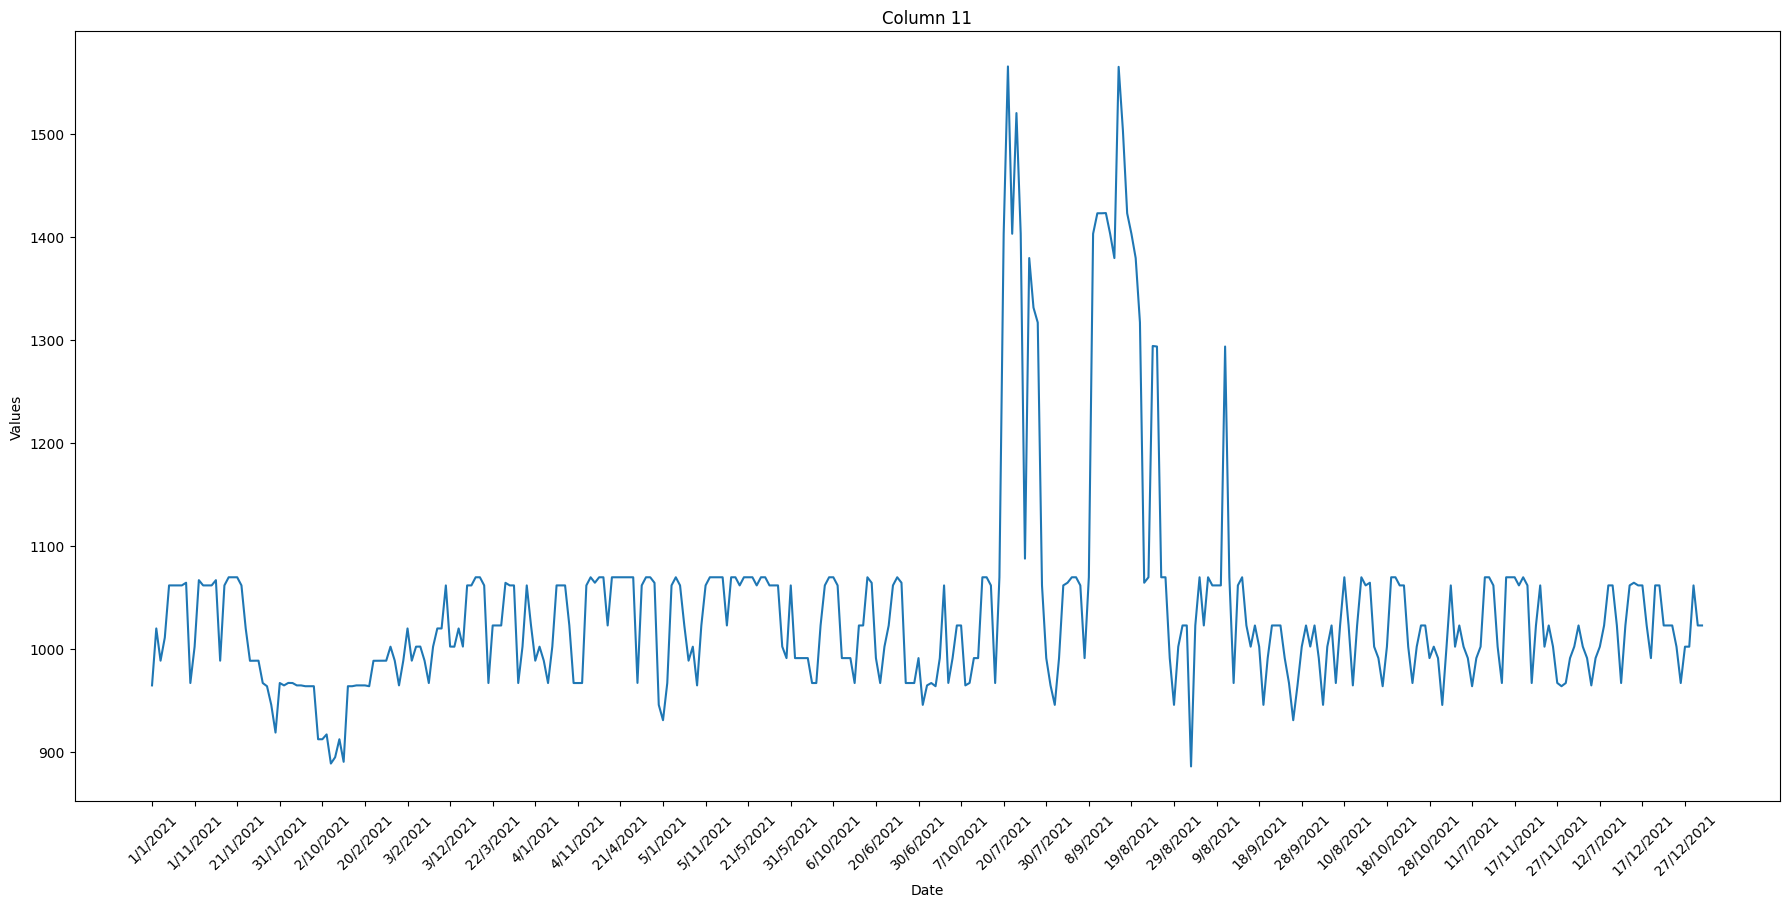

In [4]:
# biểu đồ biểu diễn giá trị của cột 11 theo thời gian
df_11 = df['11']
df11_bin = df['11']
plt.figure(figsize=(22,10))
plt.plot(df['Day'],df['11'])
plt.title("Column 11")
plt.xlabel("Date")
plt.ylabel("Values")
plt.xticks(df['Day'][::10], df['Day'][::10], rotation=45)
plt.show()

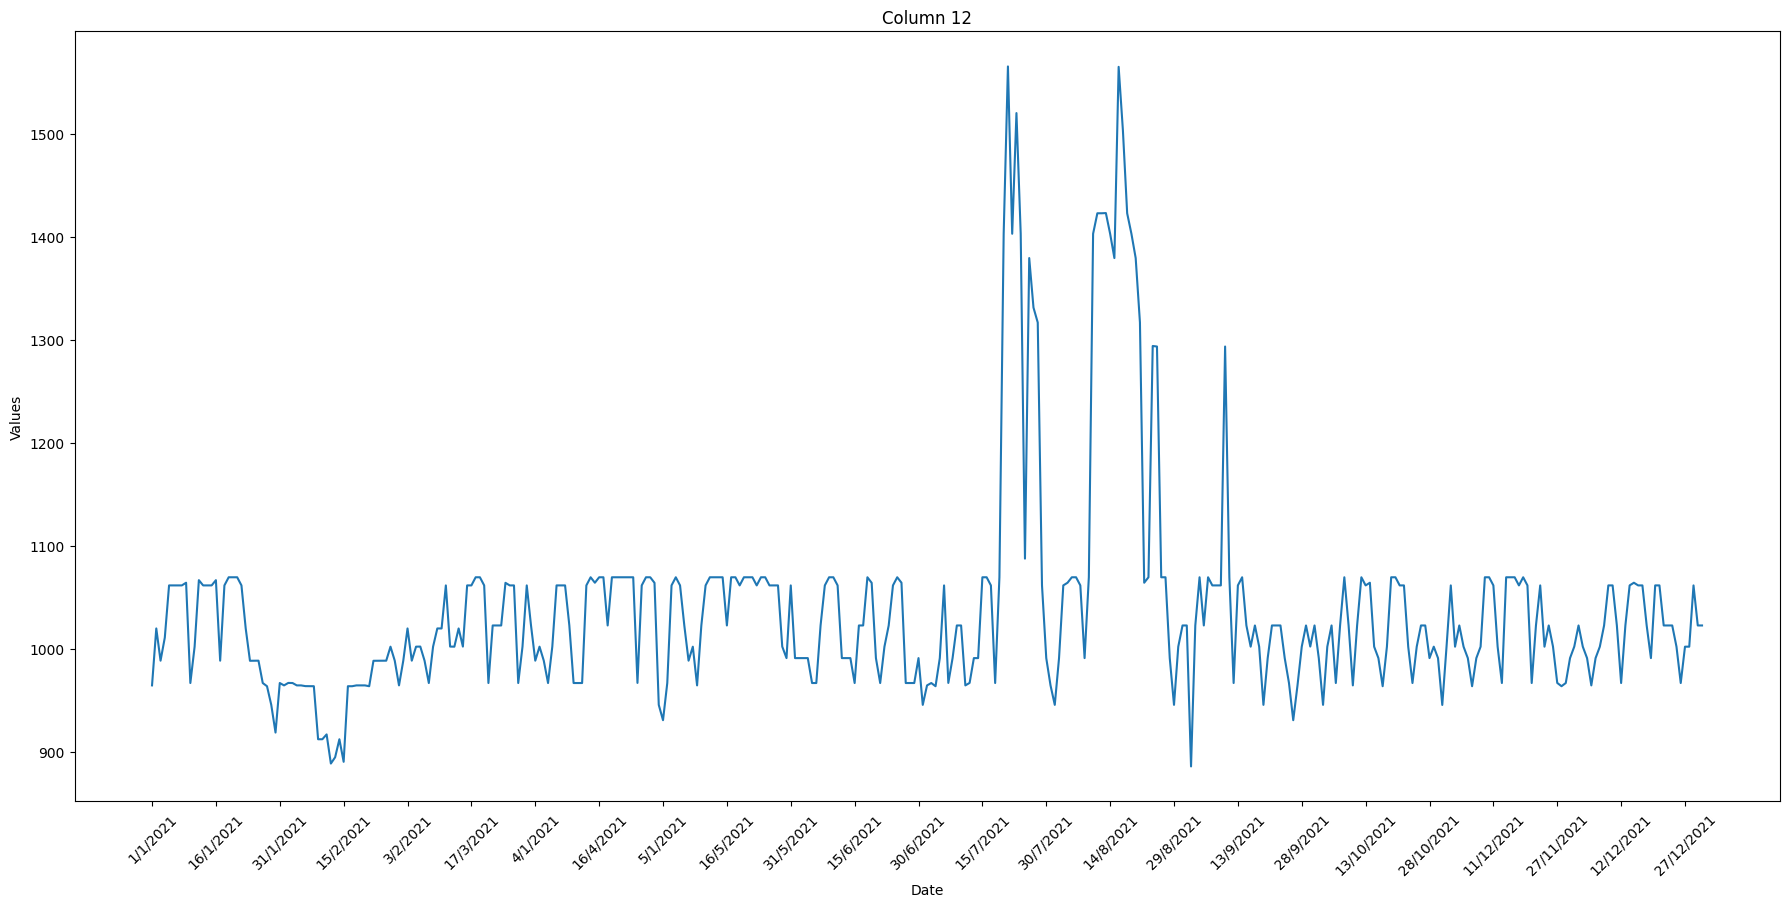

In [5]:
# biểu đồ biểu diễn giá trị của cột 12 theo thời gian
df_11 = df['12']
df11_bin = df['12']
plt.figure(figsize=(22,10))
plt.plot(df['Day'],df['12'])
plt.title("Column 12")
plt.xlabel("Date")
plt.ylabel("Values")
plt.xticks(df['Day'][::15], df['Day'][::15], rotation=45)
plt.show()

In [6]:
transformer = StandardScaler()
X = transformer.fit_transform(np.array(df[['11', '12']]))

In [7]:
X[:5]

array([[-0.72294258, -0.72294657],
       [-0.19629161, -0.19629459],
       [-0.49437796, -0.49438151],
       [-0.28105099, -0.28105413],
       [ 0.20179177,  0.20178954]])

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\

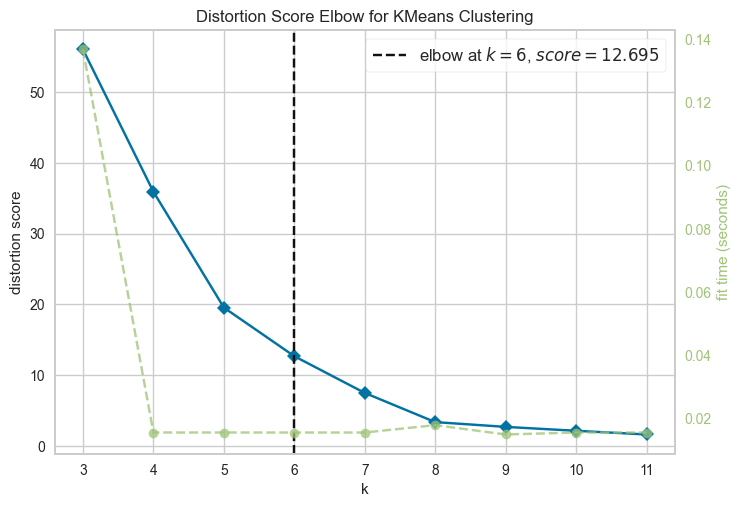

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(3,12))
Elbow_M.fit(X)
Elbow_M.show()

Model Gaussian

chạy với n_components = 6

In [9]:
BGM = BayesianGaussianMixture(n_components=6,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [10]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=['11', '12']) 
df_new[[f'predict_proba_{i}' for i in range(6)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(6):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.5)].index
    train_index = np.concatenate((train_index, n_inx))

In [11]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][['11', '12']]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(5)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = ['11', '12'])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = ['11', '12'])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model)

[200]	valid_0's multi_logloss: 0.000177301
[400]	valid_0's multi_logloss: 0.000177301
[200]	valid_0's multi_logloss: 0.000222285
[400]	valid_0's multi_logloss: 0.000222285
[200]	valid_0's multi_logloss: 0.000215846
[400]	valid_0's multi_logloss: 0.000215846
[200]	valid_0's multi_logloss: 1.15983e-05
[400]	valid_0's multi_logloss: 1.15469e-05
[600]	valid_0's multi_logloss: 1.15131e-05
[800]	valid_0's multi_logloss: 1.14892e-05
[1000]	valid_0's multi_logloss: 1.14716e-05
[1200]	valid_0's multi_logloss: 1.14579e-05
[1400]	valid_0's multi_logloss: 1.14471e-05
[1600]	valid_0's multi_logloss: 1.14384e-05
[1800]	valid_0's multi_logloss: 1.14311e-05
[2000]	valid_0's multi_logloss: 1.1425e-05
[2200]	valid_0's multi_logloss: 1.14197e-05
[2400]	valid_0's multi_logloss: 1.14152e-05
[2600]	valid_0's multi_logloss: 1.14113e-05
[2800]	valid_0's multi_logloss: 1.14078e-05
[3000]	valid_0's multi_logloss: 1.14048e-05
[3200]	valid_0's multi_logloss: 1.14021e-05
[3400]	valid_0's multi_logloss: 1.13996e-05

In [12]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[['11', '12']])

In [13]:
labels=np.argmax(lgb_preds,axis=1)

In [14]:
u = np.unique(labels)
u

array([0, 1, 2], dtype=int64)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6428\4234326658.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df['11'], df['12'], s=40, marker='o', cmap = 'rainbow' )


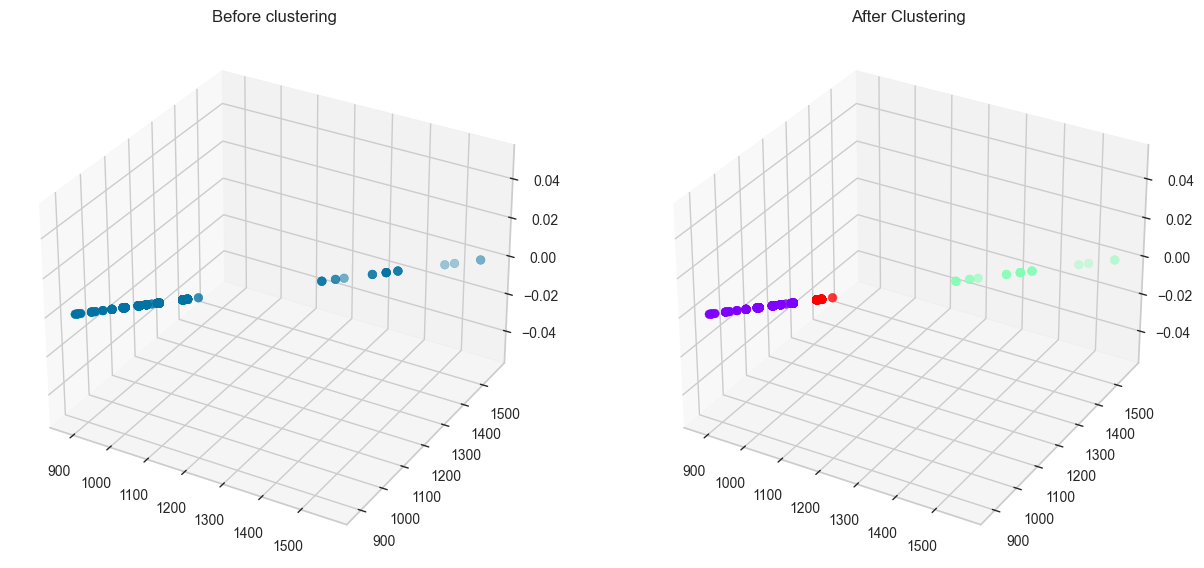

In [15]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(df['11'], df['12'], s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(df['11'], df['12'], s=40, c=df["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

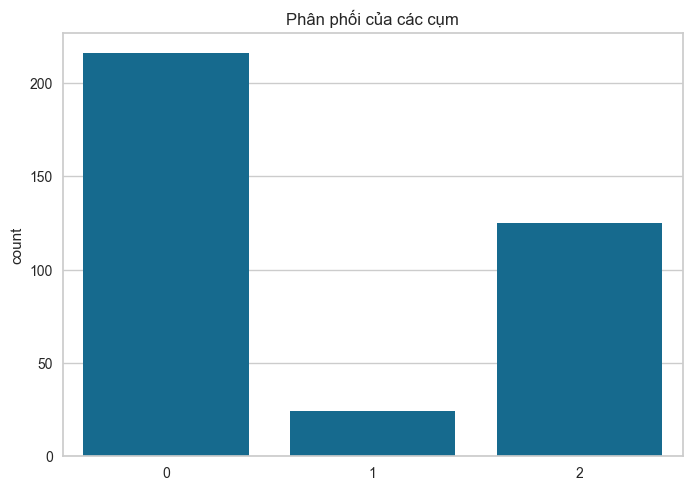

In [16]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

chạy với n_components = 4

In [17]:
BGM = BayesianGaussianMixture(n_components=4,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [18]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=['11', '12']) 
df_new[[f'predict_proba_{i}' for i in range(4)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(6):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.5)].index
    train_index = np.concatenate((train_index, n_inx))

In [19]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][['11', '12']]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(5)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = ['11', '12'])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = ['11', '12'])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model)

[200]	valid_0's multi_logloss: 0.000178168
[400]	valid_0's multi_logloss: 0.000178168
[200]	valid_0's multi_logloss: 0.000223548
[400]	valid_0's multi_logloss: 0.000223548
[200]	valid_0's multi_logloss: 0.000215846
[400]	valid_0's multi_logloss: 0.000215846
[200]	valid_0's multi_logloss: 1.11267e-05
[400]	valid_0's multi_logloss: 1.10783e-05
[600]	valid_0's multi_logloss: 1.10462e-05
[800]	valid_0's multi_logloss: 1.10235e-05
[1000]	valid_0's multi_logloss: 1.10066e-05
[1200]	valid_0's multi_logloss: 1.09935e-05
[1400]	valid_0's multi_logloss: 1.09831e-05
[1600]	valid_0's multi_logloss: 1.09746e-05
[1800]	valid_0's multi_logloss: 1.09675e-05
[2000]	valid_0's multi_logloss: 1.09616e-05
[2200]	valid_0's multi_logloss: 1.09565e-05
[2400]	valid_0's multi_logloss: 1.09522e-05
[2600]	valid_0's multi_logloss: 1.09483e-05
[2800]	valid_0's multi_logloss: 1.0945e-05
[3000]	valid_0's multi_logloss: 1.0942e-05
[3200]	valid_0's multi_logloss: 1.09393e-05
[3400]	valid_0's multi_logloss: 1.0937e-05
[

In [20]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[['11', '12']])

In [21]:
labels=np.argmax(lgb_preds,axis=1)

In [22]:
u = np.unique(labels)
u

array([0, 1, 2], dtype=int64)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6428\4234326658.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df['11'], df['12'], s=40, marker='o', cmap = 'rainbow' )


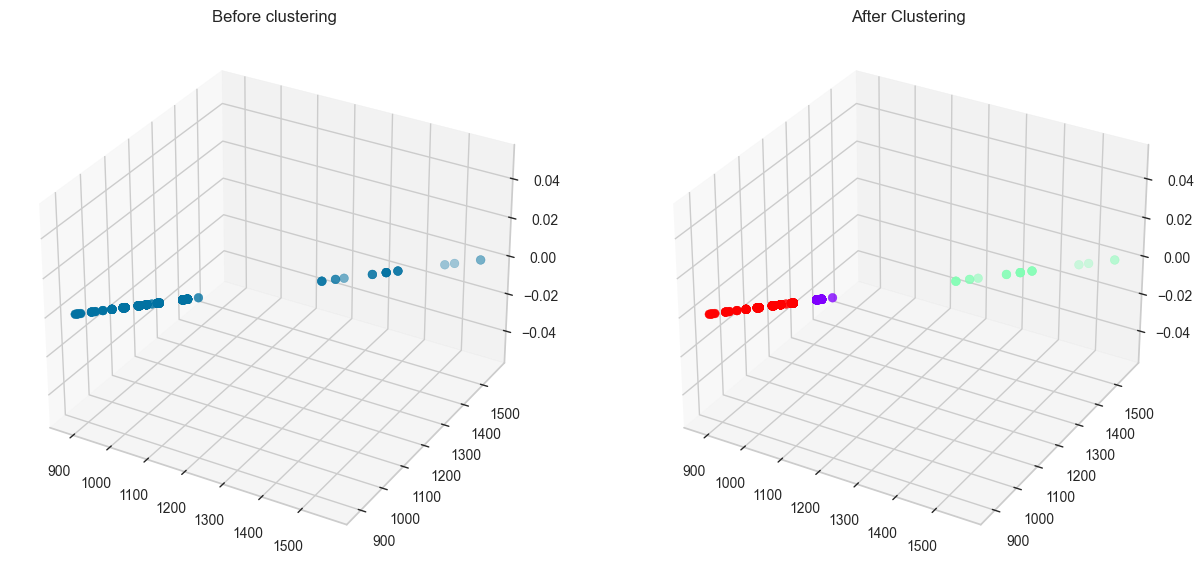

In [23]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(df['11'], df['12'], s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(df['11'], df['12'], s=40, c=df["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

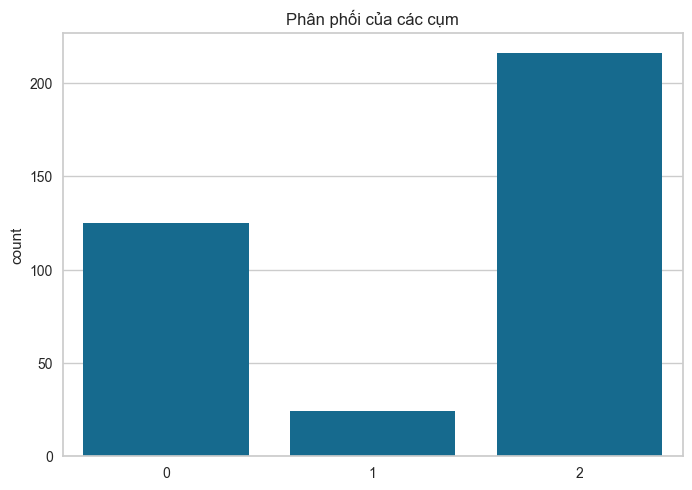

In [24]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

Dự đoán giá trị tương lai

In [25]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import GRU

In [26]:
feats = ['Day', '11', '12']
df = df[feats]
df

,Day,11,12
0,1/1/2021,964.4,964.4
1,1/2/2021,1019.7,1019.7
2,1/3/2021,988.4,988.4
3,1/4/2021,1010.8,1010.8
4,1/5/2021,1061.5,1061.5
...,...,...,...
360,27/12/2021,1002.0,1002.0
361,28/12/2021,1002.0,1002.0
362,29/12/2021,1061.5,1061.5
363,30/12/2021,1022.6,1022.6


In [27]:
df['Day'] = pd.to_datetime(df['Day'], format='%d/%m/%Y')
df.sort_values(by='Day', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [28]:
test_size = df[df['Day'].dt.month==12].shape[0]
test_size

31

In [29]:
import plotly.express as px
fig = px.line(y=df['11'], x=df['Day'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Day", 
                  yaxis_title="11",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

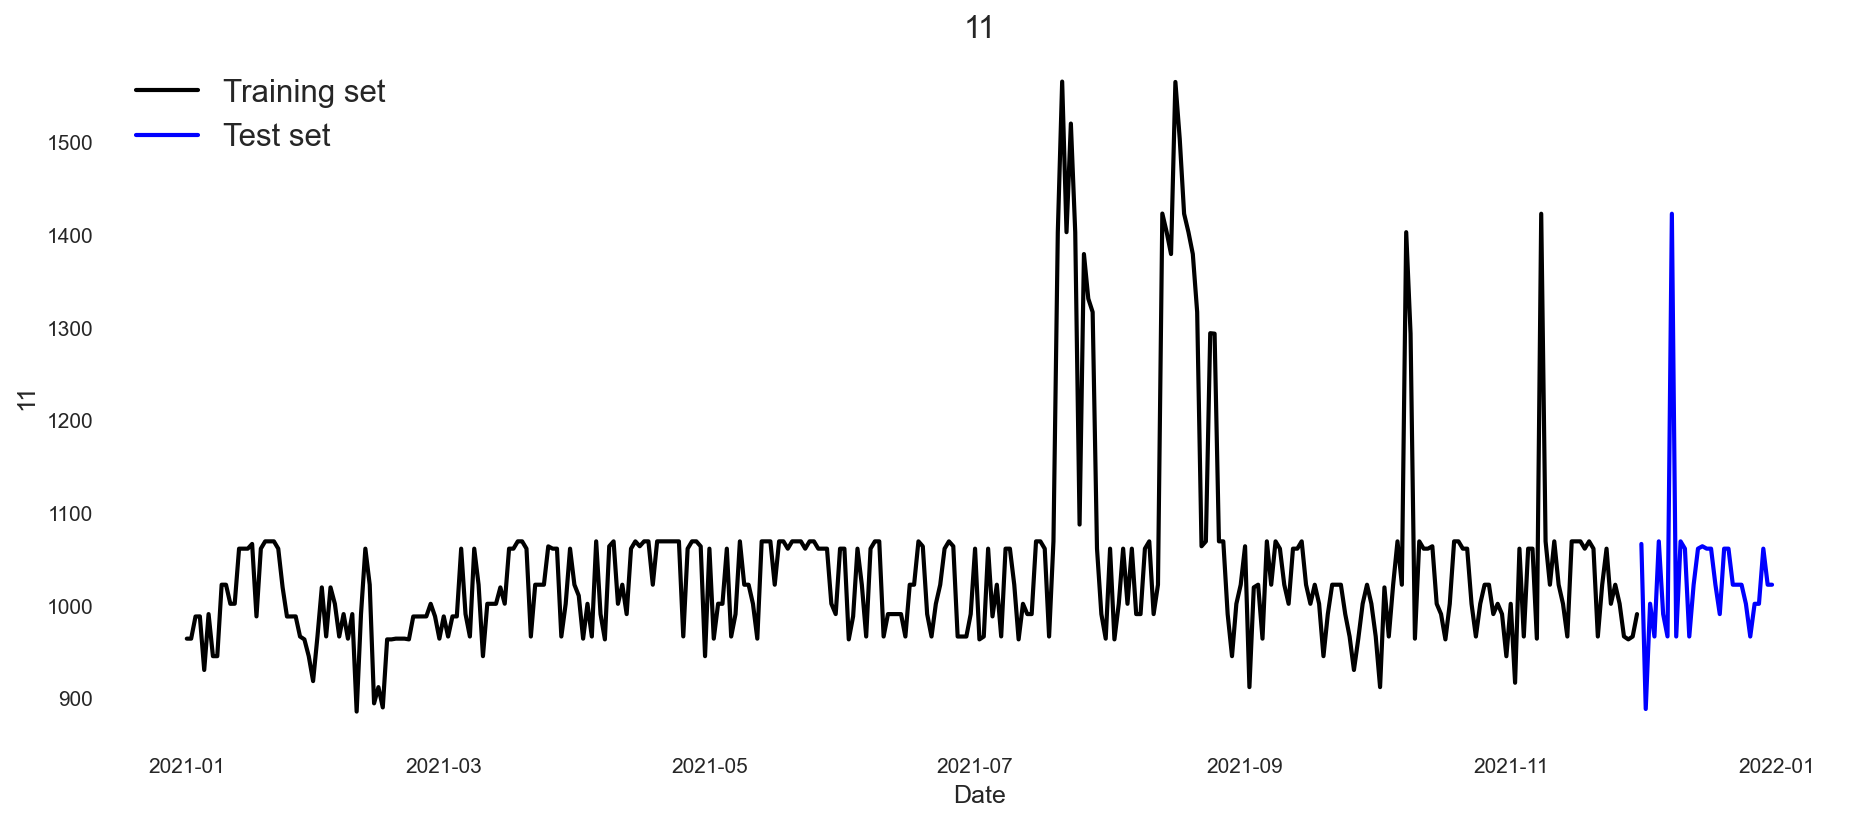

In [30]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Day'][:-test_size], df['11'][:-test_size], color='black', lw=2)
plt.plot(df['Day'][-test_size:], df['11'][-test_size:], color='blue', lw=2)
plt.title('11', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('11', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['11']])

MinMaxScaler()

In [32]:
window_size = 10

In [33]:
train_data = df[['11']][:-test_size]
train_data = scaler.transform(train_data)

In [34]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [35]:
test_data = df[['11']][-test_size-window_size:]
test_data = scaler.transform(test_data)

In [36]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [37]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [38]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [39]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (324, 10, 1)
y_train Shape:  (324, 1)
X_test Shape:   (31, 10, 1)
y_test Shape:   (31, 1)


In [40]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = GRU(units = 64, return_sequences=False)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [41]:
model = define_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1397 - val_loss: 0.0731
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1015 - val_loss: 0.0508
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0723 - val_loss: 0.0084
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - val_loss: 0.0163
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0276 - val_loss: 0.0090
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0200 - val_loss: 0.0090
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0311 - val_loss: 0.0093
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - val_loss: 0.0099
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0217 - val_loss: 0.0085
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0225 - val_loss: 0.0106
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0236 - val_loss: 0.0088
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198 - val_l

In [42]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


In [43]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, y_pred)

In [44]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)

Test Loss: 0.01873776689171791
Test MAPE: 1.8225317760361277


In [45]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

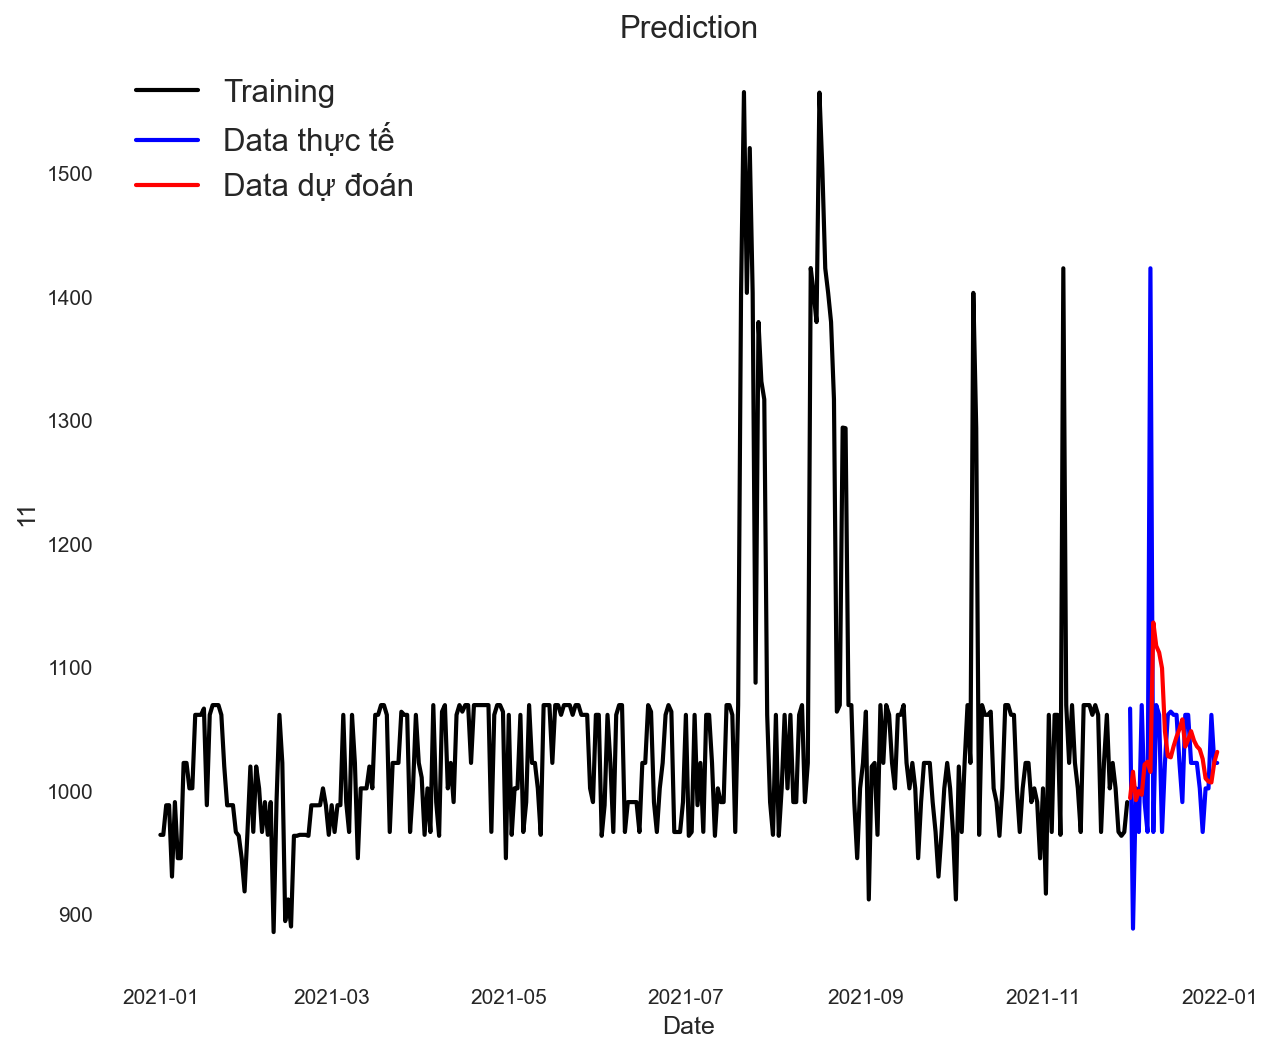

In [46]:
plt.figure(figsize=(10, 8), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Day'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Day'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Day'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('11', fontsize=12)
plt.legend(['Training', 'Data thực tế', 'Data dự đoán'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [47]:
/+

14